In [1]:
import pandas as pd
import os
import numpy as np

cur_dir = os.getcwd()
path = os.path.join(cur_dir,'dataset','train.csv')
path

df_train = pd.read_csv( os.path.join(cur_dir,'dataset','train.csv'), sep=',' )
df_movies = pd.read_csv( os.path.join(cur_dir,'dataset','movies.csv'), sep='::' )
df_users = pd.read_csv( os.path.join(cur_dir,'dataset','users.csv'), sep='::' )
df_test = pd.read_csv( os.path.join(cur_dir,'dataset','test.csv'), sep=',' )
df_SampleSubmisson = pd.read_csv( os.path.join(cur_dir,'dataset','SampleSubmisson.csv'), sep=',' )

mean = df_train.Rating.mean()
std = df_train.Rating.std()
df_train['Rating_normalized'] = (df_train['Rating'] - mean)/std

all_user = np.concatenate([df_train.UserID,df_test.UserID],axis=0)
all_movie = np.concatenate([df_train.MovieID,df_test.MovieID],axis=0)
print(all_user.shape)
print(all_movie.shape)
all_user = np.unique(all_user)
all_movie = np.unique(all_movie)
print(all_user.shape)
print(all_movie.shape)


df_all_movie = pd.DataFrame({'movie_id':all_movie})
df_all_movie['movie_index'] = df_all_movie.index

df_all_user = pd.DataFrame({'user_id':all_user})
df_all_user['user_index'] = df_all_user.index


movie_id_to_index = df_all_movie.set_index('movie_id').to_dict()
movie_id_to_index = movie_id_to_index['movie_index']
user_id_to_index = df_all_user.set_index('user_id').to_dict()
user_id_to_index = user_id_to_index['user_index']

df_train['user_index'] =  df_train.apply(lambda row: user_id_to_index[row.UserID] ,axis=1)
df_train['movie_index'] =  df_train.apply(lambda row: movie_id_to_index[row.MovieID] ,axis=1)

df_train


user_train = df_train.user_index
movie_train = df_train.movie_index
rating_train = df_train.Rating


/data1/home/feynman52/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.
/data1/home/feynman52/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


(1000209,)
(1000209,)
(6040,)
(3706,)


# w/i & w/o bias, w/o normalization

In [2]:
from keras.layers import Input, Dense, Embedding, Flatten, dot, add
from keras.models import Model
from keras.utils import get_custom_objects
import keras.backend as K
from sklearn.utils import shuffle
import matplotlib.pylab as plt

Using TensorFlow backend.


In [3]:
n_users= len(user_train)
n_movies= len(movie_train)
latent_dim = 20

In [4]:
def my_model(is_bias):

    # build model---------------------------------------------------------
    user_input = Input(shape=(1,))
    movie_input = Input(shape=(1,))

    user_vecter = Embedding(n_users, latent_dim, embeddings_initializer="random_normal")(user_input)
    user_vecter = Flatten()(user_vecter)
    movie_vecter = Embedding(n_movies, latent_dim, embeddings_initializer="random_normal")(movie_input)
    movie_vecter = Flatten()(movie_vecter)
    rating_predict = dot([user_vecter,movie_vecter],axes=1)
    
    if is_bias:
        user_bias = Embedding(n_users, 1, embeddings_initializer="zeros")(user_input)
        user_bias = Flatten()(user_bias)
        movie_bias = Embedding(n_movies, 1, embeddings_initializer="zeros")(movie_input)
        movie_bias = Flatten()(movie_bias)
        rating_predict = add([rating_predict,user_bias,movie_bias])

    model = Model([user_input,movie_input],rating_predict)

    # compile model---------------------------------------------------------
    def rmse(y_true, y_pred):
        y_pred = K.clip(y_pred, 1.0, 5.0)
        return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))
    get_custom_objects().update({"rmse": rmse})

    model.compile(loss="mse", optimizer="adam", metrics=[rmse])

    model.summary()

    # fit model---------------------------------------------------------
    batch_size=1000
    epochs = 10

    user_train2, movie_train2, rating_train2 = shuffle(user_train, movie_train, rating_train)


    history = model.fit([user_train2, movie_train2],
                        rating_train2,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.1,
                        shuffle=True)
    
    # plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    
    

----------------------------------------------------------------------
-----------------------------------False-----------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 20)        17997460    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 20)        17997460

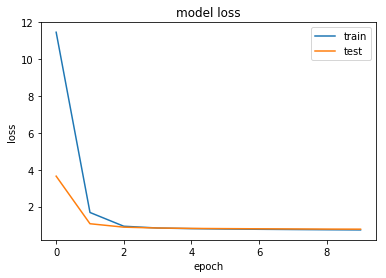

----------------------------------------------------------------------
-----------------------------------True-----------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 20)        17997460    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 20)        17997460 

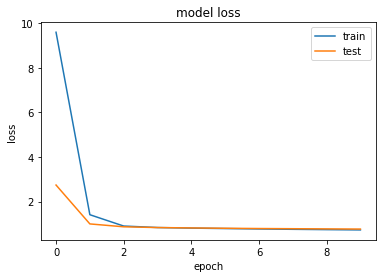

In [5]:
for is_bias in [False,True]:
    print('----------------------------------------------------------------------')
    print('-----------------------------------%s-----------------------------------'%(is_bias))
    my_model(is_bias)
    
    
    
    

# plot different model in one figure

In [7]:
def return_model(is_bias):

    # build model---------------------------------------------------------
    user_input = Input(shape=(1,))
    movie_input = Input(shape=(1,))

    user_vecter = Embedding(n_users, latent_dim, embeddings_initializer="random_normal")(user_input)
    user_vecter = Flatten()(user_vecter)
    movie_vecter = Embedding(n_movies, latent_dim, embeddings_initializer="random_normal")(movie_input)
    movie_vecter = Flatten()(movie_vecter)
    rating_predict = dot([user_vecter,movie_vecter],axes=1)
    
    if is_bias:
        user_bias = Embedding(n_users, 1, embeddings_initializer="zeros")(user_input)
        user_bias = Flatten()(user_bias)
        movie_bias = Embedding(n_movies, 1, embeddings_initializer="zeros")(movie_input)
        movie_bias = Flatten()(movie_bias)
        rating_predict = add([rating_predict,user_bias,movie_bias])

    model = Model([user_input,movie_input],rating_predict)

    # compile model---------------------------------------------------------
    def rmse(y_true, y_pred):
        y_pred = K.clip(y_pred, 1.0, 5.0)
        return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))
    get_custom_objects().update({"rmse": rmse})

    model.compile(loss="mse", optimizer="adam", metrics=[rmse])

    return model
    

In [11]:
model_bias_true = return_model(True)
model_bias_true.summary()

batch_size=1000
epochs = 10
user_train2, movie_train2, rating_train2 = shuffle(user_train, movie_train, rating_train)

history_bias_true = model_bias_true.fit([user_train2, movie_train2],
                                        rating_train2,
                                        batch_size=batch_size,
                                        epochs=epochs,
                                        validation_split=0.1,
                                        shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 20)        17997460    input_11[0][0]                   
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1, 20)        17997460    input_12[0][0]                   
__________________________________________________________________________________________________
flatten_13

In [12]:
model_bias_false = return_model(False)
model_bias_false.summary()

batch_size=1000
epochs = 10
user_train2, movie_train2, rating_train2 = shuffle(user_train, movie_train, rating_train)

history_bias_false = model_bias_false.fit([user_train2, movie_train2],
                                            rating_train2,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            validation_split=0.1,
                                            shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 1, 20)        17997460    input_13[0][0]                   
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1, 20)        17997460    input_14[0][0]                   
__________________________________________________________________________________________________
flatten_17

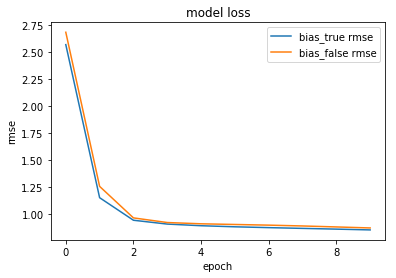

In [14]:


# plot
plt.plot(history_bias_true.history['rmse'],label='bias_true rmse')
plt.plot(history_bias_false.history['rmse'],label='bias_false rmse')
plt.title('model loss')
plt.ylabel('rmse')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
plt.legend()
plt.show()


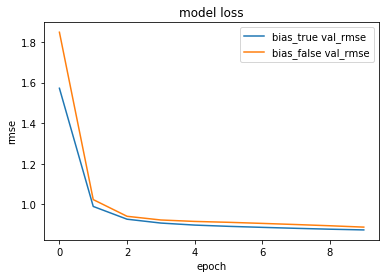

In [15]:


# plot
plt.plot(history_bias_true.history['val_rmse'],label='bias_true val_rmse')
plt.plot(history_bias_false.history['val_rmse'],label='bias_false val_rmse')
plt.title('model loss')
plt.ylabel('rmse')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
plt.legend()
plt.show()
